<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis - Final Project</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Data Collection</h2>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Julia King</h4>
</div>
<br>

In [44]:
# import chunk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
from pytrends.request import TrendReq
from copy import deepcopy

# 1. Using google trends, determine spikes in public interest concerning 15-minute cities.

In [12]:
# obtain NID cookie to avoid TooManyRequestsError & obtain suggestions

session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

tr = TrendReq(hl = "en-GB", requests_args = {'headers': {'Cookie': f'NID={nid_cookie}'}}, retries = 5)
sugs = tr.suggestions("15-minute city")
sugs

[{'mid': '/g/11hk3_sx0c', 'title': '15-minute city', 'type': 'Topic'},
 {'mid': '/g/12bm1xq9d',
  'title': 'Lonely Planet Berlin',
  'type': 'Book by Andrea Schulte-Peevers'},
 {'mid': '/g/11f51x6b_s',
  'title': 'Private Vegas',
  'type': 'Book by James Patterson and Maxine Paetro'},
 {'mid': '/g/11vqrp46gt',
  'title': 'Good People Break Bad Laws: Civil Disobedience in the Modern Age',
  'type': 'Book by Topher Field'},
 {'mid': '/m/02_286', 'title': 'New York', 'type': 'City in New York State'}]

In [13]:
# extract the relevant query term

query_list = [sug["mid"] for sug in sugs if (sug["title"] == "15-minute city") and (sug["type"] == "Topic")]

query_list

['/g/11hk3_sx0c']

In [14]:
# build payload & obtain interest over time

def get_interest_over_time(trendreq_obj : TrendReq, kw_list : list, timeframe : str, geo : str) -> pd.DataFrame:
    """Given a trendreq object and search queries, returns the google trends interest over time.

    Args:
        trendreq_obj (TrendReq): TrendReq object, allows for preconfigured hl and request_args to avoid TooManyRequestsError
        kw_list (list): list of keywords to get trends for. Must be of length <= 5 due to google trends limit
        timeframe (str): Timeframe in the format "yyyy-mm-dd yyyy-mm-dd" identifying start and end of the timeframe
        geo (str): location code, ex US for USA and DE for Germany

    Returns:
        pd.DataFrame: Object returned by google trends
    """
    
    # make actual request
    trendreq_obj.build_payload(kw_list = kw_list, timeframe = timeframe, geo = geo)
    return trendreq_obj.interest_over_time()

In [15]:
# get interest and save to csv

gtrends_df = get_interest_over_time(tr, kw_list = query_list, timeframe = "2020-01-01 2024-06-30", geo = "US") # kw_list is query term for 15 minute city (topic). Using topic instead of search term to cover variants
gtrends_df["date"] = gtrends_df.index
gtrends_df["volume"] = gtrends_df.iloc[:,0]
gtrends_df = gtrends_df[["date", "volume"]]

# save to csv
gtrends_df.to_csv("data/gtrends.csv", index = False)

RetryError: HTTPSConnectionPool(host='trends.google.com', port=443): Max retries exceeded with url: /trends/api/widgetdata/multiline?req=%7B%22time%22%3A+%222020-01-01+2024-06-30%22%2C+%22resolution%22%3A+%22WEEK%22%2C+%22locale%22%3A+%22en-GB%22%2C+%22comparisonItem%22%3A+%5B%7B%22geo%22%3A+%7B%22country%22%3A+%22US%22%7D%2C+%22complexKeywordsRestriction%22%3A+%7B%22keyword%22%3A+%5B%7B%22type%22%3A+%22ENTITY%22%2C+%22value%22%3A+%22%2Fg%2F11hk3_sx0c%22%7D%5D%7D%7D%5D%2C+%22requestOptions%22%3A+%7B%22property%22%3A+%22%22%2C+%22backend%22%3A+%22IZG%22%2C+%22category%22%3A+0%7D%2C+%22userConfig%22%3A+%7B%22userType%22%3A+%22USER_TYPE_SCRAPER%22%7D%7D&token=APP6_UEAAAAAZrIuQSYqPv0JZt30WVTNb1R2SEYaU9dB&tz=360 (Caused by ResponseError('too many 429 error responses'))

In [17]:
# load from csv 

gtrends_df = pd.read_csv("data/gtrends.csv")
gtrends_df['date'] = pd.to_datetime(gtrends_df["date"])

gtrends_df.head(3)

,date,volume
0,2019-12-29,0
1,2020-01-05,0
2,2020-01-12,0


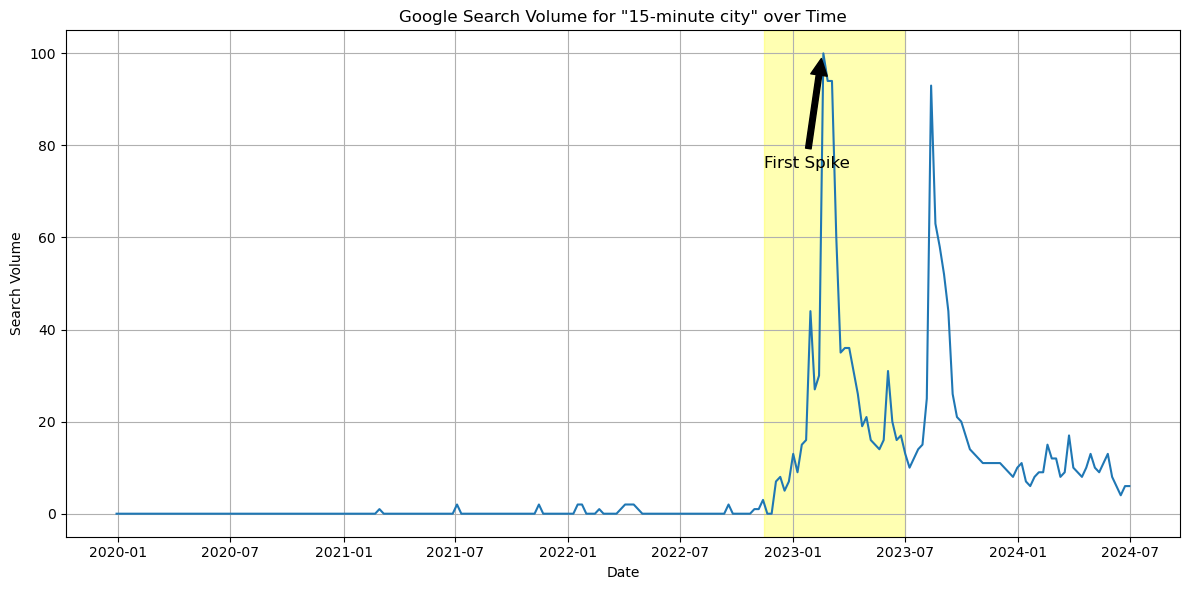

In [18]:
# create plot of google trends

plt.figure(figsize = (12, 6))

plt.plot(gtrends_df["date"], gtrends_df["volume"])

# manual, rough first spike marker
plt.axvspan(pd.to_datetime("2022-11-15"), pd.to_datetime("2023-07-01"), color = "yellow", alpha = 0.3)
plt.annotate("First Spike", xy = (pd.to_datetime("2023-02-17"), gtrends_df.iloc[:, 1].max()),
            xytext = (pd.to_datetime("2022-11-15"), gtrends_df.iloc[:, 1].max() - 25),
            arrowprops = dict(facecolor = "black", shrink = 0.05),
            fontsize = 12)

# Grid, legend + layout
plt.title("Google Search Volume for \"15-minute city\" over Time")
plt.xlabel("Date")
plt.ylabel("Search Volume")
plt.grid(True)
plt.tight_layout()

plt.show()

The plot shows 4 different "phases": 
1. The phase before the first spike, which is hypothesized to contain mostly educational videos on the concept of 15-minute cities.
2. The first spike, which is hypothesized to be caused by content presenting 15-minute cities as a conspiracy.
3. The second spike, which may be caused by mainstream media coverage of the conspiracy theories.
4. The phase after both spikes, where search volume has returned to a steady, if slightly elevated, level.

Thus, to identify the different phases, differences in rolling averages are checked. The splits should occur as follows:
1. The differences turn from ~0 to positive, indicating the beginning of the first spike.
2. The differences turn from negative to neutral and positive again, indicating the end of the first and beginning of the second spike.
3. The differences turn neutral again, indicating the end of the spikes.

In [19]:
# identify 
from scipy.signal import find_peaks

# compute differences in rolling averages
gtrends_df["rolling_mean"] = gtrends_df["volume"].rolling(window = 6, center = False).mean().shift(-5)
gtrends_df["mean_diff"] = gtrends_df["rolling_mean"].diff()

In [20]:
# find peaks, which can then be used to find start (& end) of peaks

peaks = list(find_peaks(gtrends_df["rolling_mean"], 
                        height = gtrends_df["rolling_mean"].quantile(0.9), 
                        distance = 10)[0])

peaks

[164, 189]

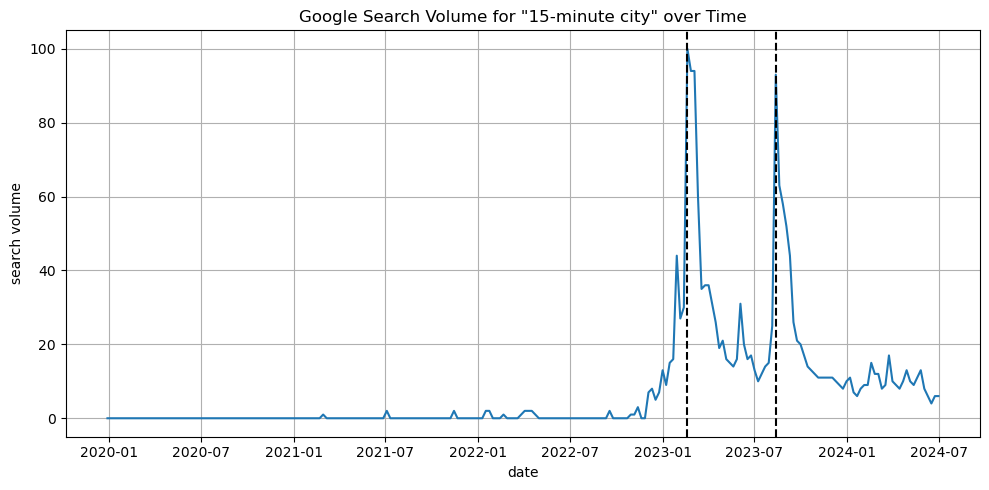

In [21]:
# recreate plot to check validity of peaks

plt.figure(figsize = (10, 5))
plt.plot(gtrends_df["date"], gtrends_df["volume"])

# add peaks
for peak in peaks:
    plt.axvline(x = gtrends_df.loc[peak, "date"], color = "black", linestyle = "--")

# Grid, legend + layout
plt.title("Google Search Volume for \"15-minute city\" over Time")
plt.xlabel("date")
plt.ylabel("search volume")
plt.grid(True)
plt.tight_layout()

plt.show()

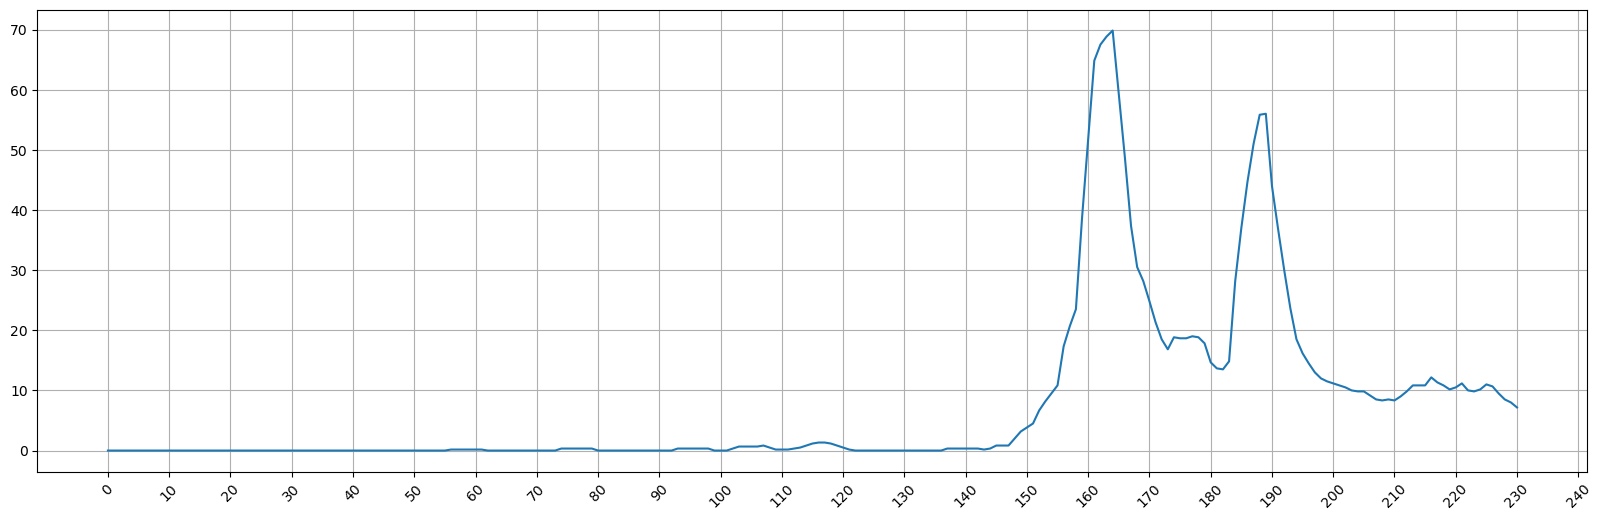

In [22]:
plt.figure(figsize = (20, 6))
plt.plot(gtrends_df["rolling_mean"])
plt.xticks(np.arange(0, 250, 10.0), rotation = 45)
plt.grid(True)

In [23]:
# function for finding the first index from a given start point & end point that matches a condition

def find_condition_index(series : pd.Series, condition, min_consecutive : int = 5, start : int = 0, end : int = None) -> int:
    """For a given series and condition, finds the first instance where a specified number of consecutive elements all meet the condition. Useful to identify the beginning / end of peaks.

    Args:
        series (pd.Series): Series to find the condition fulfilled in.
        condition (callable): A function that takes a series & returns true/false for each element if it meets/does not meet the condition.
        start (int, optional): The starting index to begin the search. Defaults to 0.
        end (int, optional): The first index not to be searched any more. Defaults to None (end of the series).
        n (int, optional): The number of consecutive elements that need to meet the condition. Defaults to 5.

    Raises:
        ValueError: If the start index is invalid.
        ValueError: If no suitable index is found where the condition is met for the specified number of consecutive elements.

    Returns:
        int: The index of the first element where the condition is met for it and the following min_consecutive - 1 elements (min_consecutive in total).
    """
    # check input validity
    if (start < 0) or (start > (len(series) - 1)):
        raise ValueError("Not a valid index")
    if (end is None):
        end = len(series)
    
    # find index where it and the next n fulfil the condition
    for i in range(start, min(len(series) - min_consecutive - 1, end)):
        if all(condition(series.iloc[i:i + min_consecutive])):
            return i
    
    # case where no index fits the description
    raise ValueError("No fitting column found.")

In [24]:
# identify start of 1st peak -> differences going from ~0 to significant positive before peaks[0]

phase_starts = [0, find_condition_index(gtrends_df["mean_diff"], condition = lambda x: x > 1, end = peaks[0])]

In [25]:
# identify start of 2nd peak -> differences going from negative to positive after peaks[0] and before peaks[1]

phase_starts.append(find_condition_index(gtrends_df["mean_diff"], condition = lambda x: x > 1, start = peaks[0], end = peaks[1]))

In [26]:
# identify start of 2nd normal phase -> differences going from negative to ~0 after peaks[1]

phase_starts.append(find_condition_index(gtrends_df["mean_diff"], condition = lambda x: abs(x) < 1, start = peaks[1]))

In [27]:
phases = [{"start_index": current, 
           "end_index": next_element - 1, 
           "color": color} for current, next_element, color in zip(phase_starts, 
                                                                   phase_starts[1:] + [len(gtrends_df) - 1], 
                                                                   ["b", "r", "g", "y"])]

In [28]:
phases

[{'start_index': 0, 'end_index': 151, 'color': 'b'},
 {'start_index': 152, 'end_index': 182, 'color': 'r'},
 {'start_index': 183, 'end_index': 198, 'color': 'g'},
 {'start_index': 199, 'end_index': 234, 'color': 'y'}]

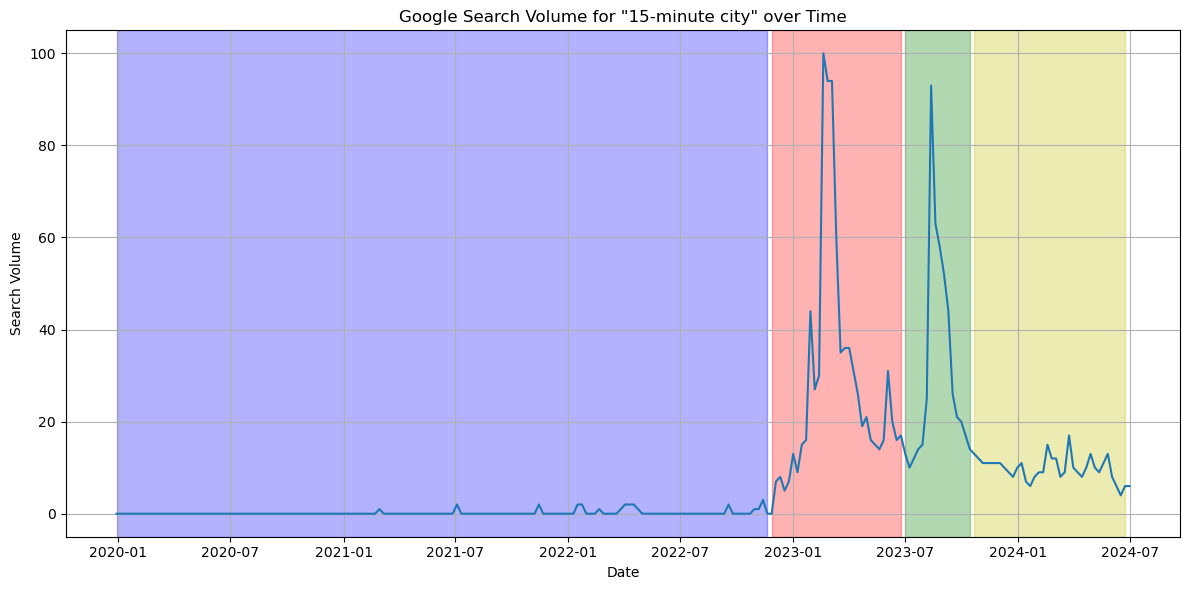

In [29]:
# plot again with the phases

plt.figure(figsize = (12, 6))

plt.plot(gtrends_df["date"], gtrends_df["volume"])

# mark the different phases
for sr_phase in phases:
    plt.axvspan(pd.to_datetime(gtrends_df.loc[sr_phase["start_index"], "date"]), gtrends_df.loc[sr_phase["end_index"], "date"], color = sr_phase["color"], alpha = 0.3)

# Grid, legend + layout
plt.title("Google Search Volume for \"15-minute city\" over Time")
plt.xlabel("Date")
plt.ylabel("Search Volume")
plt.grid(True)
plt.tight_layout()

plt.show()

In order to prevent imbalanced group sizes and to avoid straining the api too much, the length of phase 1 will be limited to the maximum length of the other phases. This is done by moving the start of phase 1 forward.

In [30]:
# limit phase 1

duration = max(phase["end_index"] - phase["start_index"] for phase in phases[1:])
phases[0]["start_index"] = phases[0]["end_index"] - duration

phases[0]["start_index"]

116

# 2. For the relevant timeframe, obtain the IDs of the most-viewed videos related to 15-minute cities per week.

## 2.1 general setup

In [31]:
# get api key

import api_keys # not included in repository, can be provided in an api_keys.py file
api_key = api_keys.YOUTUBE

In [32]:
# generate a list of weeks for each phase

def generate_weeks(start_date: pd.Timestamp, end_date: pd.Timestamp) -> list:
    """Given a start and end date, generates a list of weeks included in the range. Weeks do not overlap, last week is shortened to only go up to the end date.

    Args:
        start_date (pd.Timestamp): Start of timeframe to generate weeks of. Weeks always start on the weekday of start_date.
        end_date (pd.Timestamp): Where to end timeframe. If this is not either exactly x weeks, 6 days, 23 hours, 59 minutes, 59 seconds OR exactly x weeks, 7 days after start date, then the last week will be shortened. 

    Returns:
        list: List of weeks
    """
    # input validation
    if end_date <= start_date:
        raise ValueError("End date must be greater than start date.")
    
    weeks = []
    current_start = start_date
    
    while current_start <= end_date:
        current_end = current_start + pd.Timedelta(days = 6, hours = 23, minutes = 59, seconds = 59)
        weeks.append((current_start, min(current_end, end_date)))
        current_start = current_start + pd.Timedelta(days = 7)
    
    # Adjust the last tuple if needed
    if weeks and weeks[-1][1] < end_date:
        weeks[-1] = (weeks[-1][0], end_date)
    
    return weeks

# add info to phases list
for sr_phase in phases:
    sr_phase["start_date"] = gtrends_df.loc[sr_phase["start_index"], "date"]
    sr_phase["end_date"] = gtrends_df.loc[sr_phase["end_index"] + 1, "date"] - pd.Timedelta(seconds = 1) # do plus 1 so last week is covered as well
    sr_phase["weeks"] = generate_weeks(sr_phase["start_date"], sr_phase["end_date"])
    
# preview
phases[0]

{'start_index': 116,
 'end_index': 151,
 'color': 'b',
 'start_date': Timestamp('2022-03-20 00:00:00'),
 'end_date': Timestamp('2022-11-26 23:59:59'),
 'weeks': [(Timestamp('2022-03-20 00:00:00'),
   Timestamp('2022-03-26 23:59:59')),
  (Timestamp('2022-03-27 00:00:00'), Timestamp('2022-04-02 23:59:59')),
  (Timestamp('2022-04-03 00:00:00'), Timestamp('2022-04-09 23:59:59')),
  (Timestamp('2022-04-10 00:00:00'), Timestamp('2022-04-16 23:59:59')),
  (Timestamp('2022-04-17 00:00:00'), Timestamp('2022-04-23 23:59:59')),
  (Timestamp('2022-04-24 00:00:00'), Timestamp('2022-04-30 23:59:59')),
  (Timestamp('2022-05-01 00:00:00'), Timestamp('2022-05-07 23:59:59')),
  (Timestamp('2022-05-08 00:00:00'), Timestamp('2022-05-14 23:59:59')),
  (Timestamp('2022-05-15 00:00:00'), Timestamp('2022-05-21 23:59:59')),
  (Timestamp('2022-05-22 00:00:00'), Timestamp('2022-05-28 23:59:59')),
  (Timestamp('2022-05-29 00:00:00'), Timestamp('2022-06-04 23:59:59')),
  (Timestamp('2022-06-05 00:00:00'), Timestam

## 2.2 prepare query parameters & results data structure

This project, especially the search endpoint, will require a lot of requests. Thus, it will be necessary to save partial results and continue on the next day. A JSON structure is used to to this.

In [33]:
# define fixed parameters

search_params_fixed = {"key" : api_key, 
                       "q" : "15-minute city", 
                       "maxResults" : 50, 
                       "order" : "viewcount", 
                       "type" : "video"}

In [34]:
# write functions to write / load the results json (separate function is necessary as it needs to store datetime values. these need to be converted to string before saving and from string when loading)

def write_search_json(search_results : list, location : str = "data/results_search.json"):
    """Writes the given object to the results file of the search endpoint. Careful not to overwrite anything!

    Args:
        json (list): the results of the search endpoint so far
        location (str, optional): File location. Defaults to "data/results_search.json".
    """
    def datetime_to_str(dt):
        return dt.isoformat()

    def convert_for_write(entry):
        result = {}
        for key, value in entry.items():
            start, end = key
            # Convert datetime objects to ISO format strings
            result[f"{datetime_to_str(start)}${datetime_to_str(end)}"] = value
        return result

    # Convert the datetimes to string format
    saveable = [convert_for_write(phase) for phase in search_results]

    # Save to json
    with open(location, "w") as f:
        json.dump(saveable, f, indent=4)



def read_search_json(location : str = "data/results_search.json") -> list:
    """Reads the results of the search endpoint so far.

    Args:
        location (str, optional): File Location. Defaults to "data/results_search.json".

    Returns:
        list: the results of the search endpoint so far
    """
    def str_to_datetime(s):
        return pd.to_datetime(s)

    def convert_after_read(entry):
        result = {}
        for key, value in entry.items():
            start_str, end_str = key.split("$")
            # Convert ISO format strings to datetime objects
            start = str_to_datetime(start_str)
            end = str_to_datetime(end_str)
            result[(start, end)] = value
        return result

    with open(location, "r") as f:
        loaded = json.load(f)

    # Apply conversion to each dictionary in the list
    search_results = [convert_after_read(entry) for entry in loaded]

    return search_results


In [35]:
# define list of dicts which will contain the results from search endpoint

# avoid unintentional resets of the results dataset
reset_results = input("Do you want to reset the results of the search endpoint? (yes/anything else): ").strip().lower()

if reset_results != "yes":
    raise Exception("Execution aborted by user.")

search_results = [{week: None for week in phase["weeks"]} for phase in phases] # list structure to keep the phases separate, easier to track later

write_search_json(search_results)

In [46]:
# load results so far

search_results = read_search_json()

## 2.3 Make search requests

In [52]:
# define wrapper function which requests only those weeks where no data has been generated yet.

def fill_search_phase(phase_results: dict, fixed_params : dict) -> dict:
    """Given the results of a phase, makes requests for every week (/every key) until quota is reached or all weeks are done.

    Args:
        phase_results (dict): dict where keys are tuples of timestamps and values are None for those elements that still need requests.
        fixed_params (dict): parameters to pass on alongside time limits.

    Returns:
        dict: phase results but updated
    """
    
    for daterange, value in phase_results.items():
        if not(value is None): # the request was already successfully obtained, the week can be skipped
            continue
        # prepare params
        current_params = fixed_params.copy()
        current_params["publishedAfter"] = daterange[0].strftime("%Y-%m-%dT%H:%M:%SZ")
        current_params["publishedBefore"] = daterange[1].strftime("%Y-%m-%dT%H:%M:%SZ")
        
        # make request & check validity
        response = requests.get(url = "https://www.googleapis.com/youtube/v3/search", params = current_params)
        if (response.ok):
            phase_results[daterange] = response
        else: # request not successful, likely due to quota constraints
            print(f"Error @ request for week {daterange} with params \n {current_params}.")
            print(f"Errorcode: {response.status_code}, meaning {response.reason}")
            return phase_results
    return phase_results

def fill_search_results(search_results: list, fixed_params : dict) -> list:
    """Given the search results list/json, makes requests for every week until quota is reached. Then returns the search results so they can be saved again. Skips those weeks where a result is already present.

    Args:
        search_results (list): json specified in section above, can already contain some results.
        fixed_params (dict): parameters to pass on alongside time limits.

    Returns:
        list: search_results object filled in as much as possible.
    """
    
    sr_copy = deepcopy(search_results)
    
    for i in range(len(sr_copy)):
        sr_copy[i] = fill_search_phase(sr_copy[i], fixed_params)
    return sr_copy

In [53]:
# define function that counts number of None entries still left in search results, purely for debugging & user info

def count_none(search_results : list) -> int:
    """Given a list of dicts, counts the total number of keys with None values in the dicts.

    Args:
        search_results (list): list of dicts

    Returns:
        int: Nr. of None values in the dicts
    """
    none_count = 0
    for phase_result in search_results:
        none_count = none_count + sum(1 for value in phase_result.values() if value is None)
    return none_count

In [ ]:
# make requests

# avoid unintentional usage of quotas
reset_results = input("Do you want to fill in the remaining search results? (yes/anything else): ").strip().lower()

if reset_results != "yes":
    raise Exception("Execution aborted by user.")

# count number of nones before to later caluclate change
none_count_before = count_none(search_results)


search_results = fill_search_results(search_results, search_params_fixed) # operates in place

# count number of nones after & print number of entries filled
none_count_after = count_none(search_results)

print(f"Nr. of None entries filled: {none_count_before - none_count_after}. Nr. Remaining: {none_count_after}.")

In [75]:
# function to extract json out of responses (was not done in requests function to minimize chance of errors from anythong other than requests, but is needed to save file as json)

def responses_to_json(search_results : list) -> list:
    """
    Converts all requests.Response objects in the input list to their JSON content.

    Args:
        search_results (list): A list of dictionaries where some values are requests.Response objects.

    Returns:
        list: A list of dictionaries with all requests.Response objects converted to JSON content.
    """      
    sr_copy = deepcopy(search_results)
    for phase_results in sr_copy:
        for daterange, value in phase_results.items():
            if isinstance(value, requests.Response):
                phase_results[daterange] = value.json()
    return sr_copy

In [76]:
# convert responses to json format

search_results = responses_to_json(search_results)

In [78]:
# save search results

write_search_json(search_results)

# 3. Obtain relevant metadata and comments for the videos.

# 4. Based on the title and description, classify the a sample of the videos as conspirative or non-conspirative by hand.

# 5. Employ supervised text analysis to classify the dataset as conspirative or non-conspirative. Evaluate the performance.

# 6. Use the emotion classification model LEIA to obtain the sentiments expressed in the comments.